This notebook determines the input parameters for the simulated datasets.
Based on the object, we look at the diffraction overlap at the various convergence semi-angle values.
We then look into deciding on the probes and step sizes in order to reach a wide range of overlap values.

In [1]:
#%matplotlib qt
%matplotlib inline

In [2]:
import numpy as np
import hyperspy.api as hs
import os
import h5py

In [3]:
from sim_utils import *

For graphene at 80 kV below are the convergence semi-angle values and the overlap between the bf disc and the first reflection of graphene at 0.01960 rad:

| Convergence semi_angle (rad)        | Overlap in reciprocal space (%)           |
| :-------------: |:-------------:| 
| **0.008**      | **-22.5** | 
| 0.010      | 1.99      | 
| 0.012      | 18.33      | 
| **0.015** | **34.70**      | 
| 0.020      | 51.00      | 
| **0.025**  | **60.80**     |   
| **0.032** | **69.37**       |   
| **0.042** | **76.67**       | 

The bold cases are corresponding to the CL aperture sizes on G-ARM in the standard STEM alignment. The other cases are included to fill in the span of large differences in convergence angles.


In [10]:
# function to get the obove values
get_overlap(0.020, 0.01960)

51.0

# sim starting parameters:
For instructions on prismatic refer to:
https://prism-em.com/tutorial-SuperSTEM/

Accelerating voltage: 80 kV

Aiming for 256*256 (to mimic single chip Medipix detector), knowing our object is 3 * 29.03 A in size, we can calculate the simulation PixelSize: 


In [13]:
29.03*1e-10*3 / (2*256)

1.7009765625000004e-11

pixel_size: 0.170 A

This gives us maximum scattering angle of 61 mrad and a detector array of 256 by 256 pixels.


In [14]:
e_0 = 80000
l = e_lambda(e_0)
pixel_size = 0.170e-10 # in m
alpha_max = l / (4 * pixel_size)
print(alpha_max)

0.061407589371815015


We can also now calculate the pixel size in reciprocal plane:

In [17]:
print('mrad per pixel: ', 0.061e3 / 128 )
print('pixel per mrad: ', (0.061e3 / 128)**-1)

mrad per pixel:  0.4765625
pixel per mrad:  2.098360655737705


Based on the above convergence semi-angle values, in each case we get two probes: 

one at zero defocus

one with maximum defocus - defined as the probe with diameter equal to half the reconstrction array, i.e. 21.775 A =  (0.170 A * 256 / 2) in this case. 

We then find the step sizes that can give us a wide range of cases:

Target probe overlap values (%): -5, 2, 15, 35, 60, 70, 80

In [18]:
pixel_size = 0.170e-10 # in m
image_size = [256, 256]
e_0 = 80000
l = e_lambda(e_0)
print('electron wavelength (m): ', l)
conv_semi_list = [0.008, 0.010, 0.012, 0.015, 0.020, 0.025, 0.032, 0.042]
def_vals = [] 
probes = []

for angle in conv_semi_list:
    # 8 focussed probes
    probe = calc_probe_size(pixel_size, image_size, l, 0, angle, plot_probe= False, return_probeArr= True)
    probes.append(probe)
    def_vals.append(0)
    # defocus values
for angle in conv_semi_list:  
    # 8 defocussed probes
    print(angle)
    def_val = max_defocus(pixel_size, image_size, l, angle)
    print(def_val)
    def_vals.append(def_val)
    probe = calc_probe_size(pixel_size, image_size, l, def_val, angle, plot_probe= False, return_probeArr= True)
    probes.append(probe)

probes = np.asanyarray(probes)

electron wavelength (m):  4.175716077283421e-12
0.008
2.8169999999999557e-08
0.01
2.6149999999999096e-08
0.012
2.447999999999904e-08
0.015
2.235999999999916e-08
0.02
1.98799999999993e-08
0.025
1.8149999999999398e-08
0.032
1.6249999999999507e-08
0.042
1.4439999999999609e-08


In [32]:
def_vals

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2.8169999999999557e-08,
 2.6149999999999096e-08,
 2.447999999999904e-08,
 2.235999999999916e-08,
 1.98799999999993e-08,
 1.8149999999999398e-08,
 1.6249999999999507e-08,
 1.4439999999999609e-08]

In [33]:
probes.shape

(16, 2)

**Total number of cases: 112**

16 probes (8 focus and 8 defocussed)
each case to be rastered on cell with 7 different probe overlap values

Total : 16 * 7

In [34]:
conv_semi_list

[0.008, 0.01, 0.012, 0.015, 0.02, 0.025, 0.032, 0.042]

In [41]:
probe_overlaps = [-5, 2, 15, 35, 60, 70, 80]
step_sizes = []
for i in np.arange(probes.shape[0]):
    for overlap in probe_overlaps:
        step_sizes.append(get_step_size(probes[i][0], overlap / 100))


In [49]:
len(probe_overlaps)

7

[Text(0, 0.5, 'step size (m)'),
 Text(0.5, 1.0, 'scan step sizes for target overlap values')]

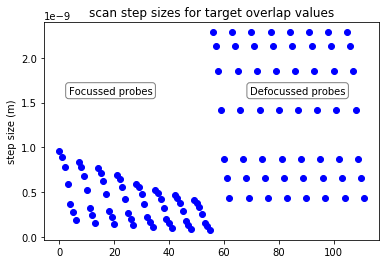

In [44]:
fig, ax = plt.subplots()

ax.plot(step_sizes, 'bo')

ax.annotate('Focussed probes', xy=(15, 1.6e-9),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, 5e-10), textcoords='offset points', ha='center')
ax.annotate('Defocussed probes', xy=(65, 1.6e-9),
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(60, 5e-10), textcoords='offset points', ha='center')
ax.set(title='scan step sizes for target overlap values',
       ylabel='step size (m)')

Text(0.5, 0, 'sim conditions')

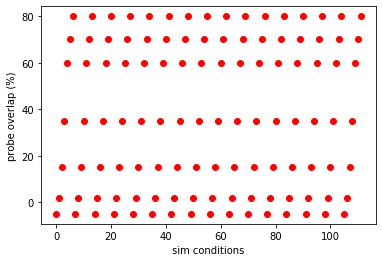

In [46]:
probe_overlaps_all = probe_overlaps * probes.shape[0]
plt.plot(probe_overlaps_all, 'ro')
plt.ylabel('probe overlap (%)')
plt.xlabel('sim conditions')

Text(0.5, 0, 'sim conditions')

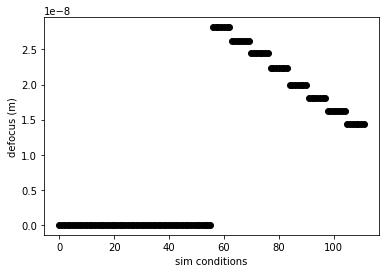

In [50]:
def_vals_all = [y for x in def_vals for y in (x,)*len(probe_overlaps)]
plt.plot(def_vals_all, 'ko')
plt.ylabel('defocus (m)')
plt.xlabel('sim conditions')

Text(0.5, 0, 'sim conditions')

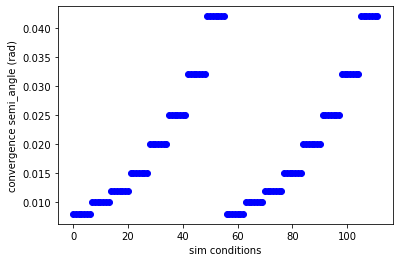

In [51]:
conv_semi_all = [y for x in conv_semi_list for y in (x,)*len(probe_overlaps)] * 2
plt.plot(conv_semi_all, 'bo')
plt.ylabel('convergence semi_angle (rad)')
plt.xlabel('sim conditions')

In [52]:
conv_semi_all = np.asarray(conv_semi_all)
def_vals_all = np.asarray(def_vals_all)
step_sizes = np.asarray(step_sizes)
sim_conditions = np.vstack((conv_semi_all, def_vals_all, step_sizes))

In [59]:
sim_conditions[:,58]
# convergence semi-angle (rad), defocus (m), step_size (m)

array([8.00000000e-03, 2.81700000e-08, 1.85034102e-09])

In [54]:
sim_conditions.shape

(3, 112)

In [55]:
np.save('sim_condtions_112', sim_conditions)

In [62]:
sim_conditions[0,:]

array([0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.01 , 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.012, 0.012, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.032, 0.032, 0.032,
       0.032, 0.032, 0.032, 0.032, 0.042, 0.042, 0.042, 0.042, 0.042,
       0.042, 0.042, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008,
       0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.012, 0.012,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 ,
       0.02 , 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.032,
       0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.042, 0.042, 0.042,
       0.042, 0.042, 0.042, 0.042])

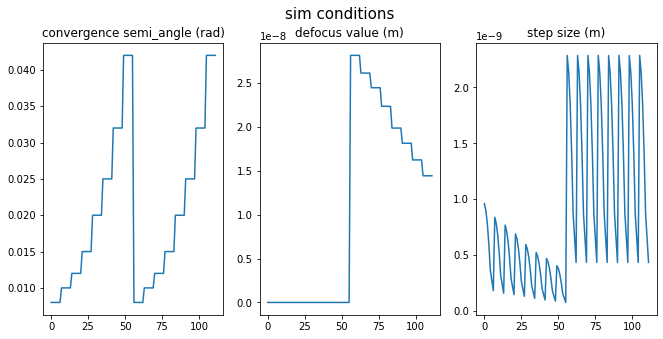

In [74]:
fig, axs = plt.subplots(1,3, figsize=(11, 5))
title = 'sim conditions'
fig.suptitle(title, fontsize = 15)

for i, ax in enumerate(axs.ravel()):
    ax.plot(sim_conditions[i,:])
    if i==0:
        ax.set_title('convergence semi_angle (rad)')
    if i==1:
        ax.set_title('defocus value (m)')
    if i==2:
        ax.set_title('step size (m)')
